In [6]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [7]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/distan_lat42.896lon-8.415p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Visibility statistics


count    90838.000000
mean      8681.925141
std       2609.865894
min         48.000000
25%       8996.000000
50%       9994.000000
75%       9994.000000
max       9994.000000
Name: visibility_o, dtype: float64

*****************************
Climatology visibility <= 1000 meters


>1000m     97%
<=1000m     3%
Name: vis_l, dtype: object

*****************************


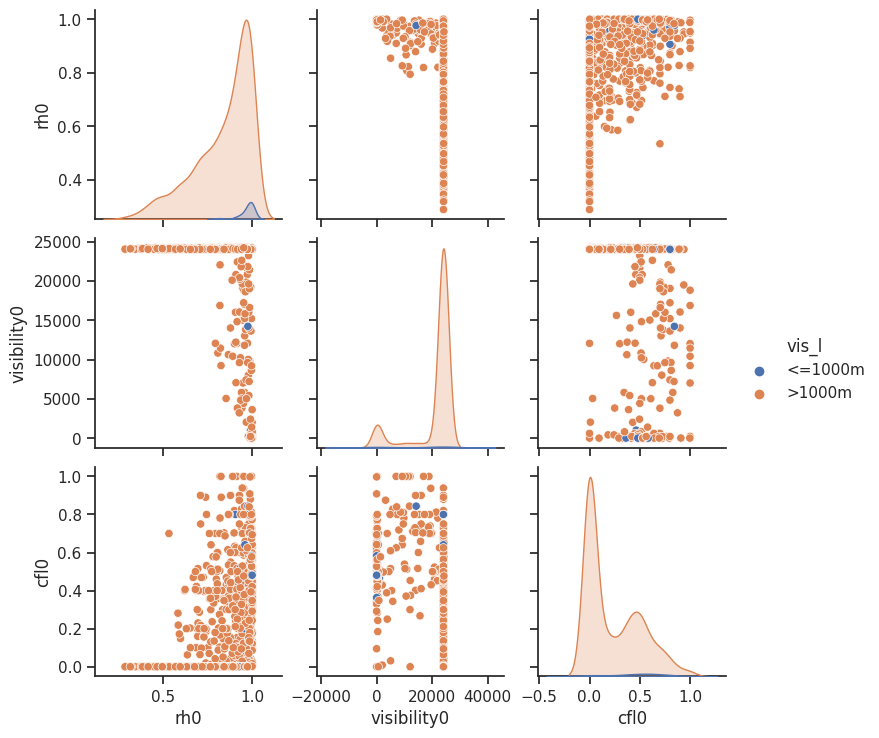

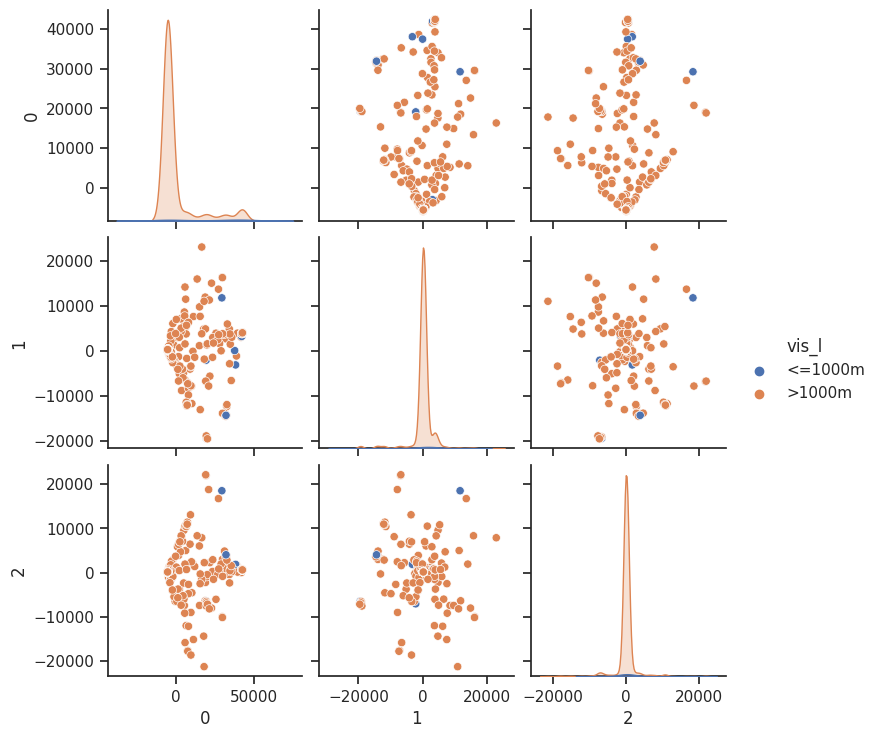

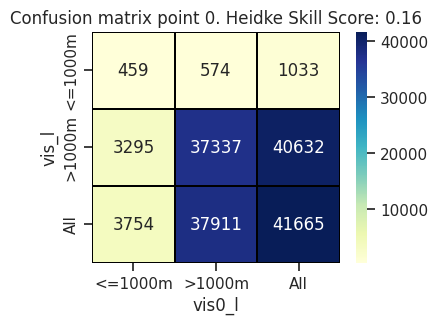

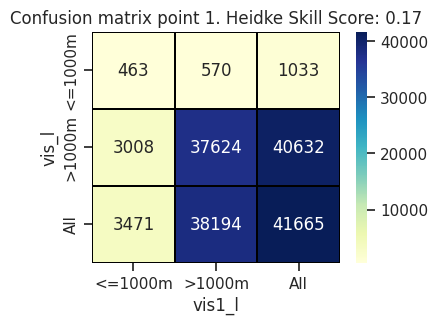

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 1616.9167240591887
Reject H0,There is an association between machine learning forecast and observed values


In [8]:
#@title Load station (visibility). Load meteorological model forecast D0. Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/LESTY2018Y2022.csv",
                          usecols =["time","visibility_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Visibility statistics")
display(station["visibility_o"].describe())

#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,1000), (1000, 40000)])
labels = ['<=1000m', '>1000m']
station["vis_l"] = pd.cut(station["visibility_o"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

print("*****************************")
print("Climatology visibility <= 1000 meters")
display(station["vis_l"].value_counts(normalize=True).map(lambda n: '{:.0%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["visibility_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["vis_l","rh0","visibility0","cfl0"]].sample(1000)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="vis_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["vis_l"] = df_all.vis_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(1000), hue="vis_l");
plt.show()

#label meteorological model variables dir0 and dir1
df_all["vis0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all["vis1_l"] = pd.cut(df_all["visibility1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.vis_l, df_all.vis0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
cm1 = pd.crosstab(df_all.vis_l, df_all.vis1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")


Round 0


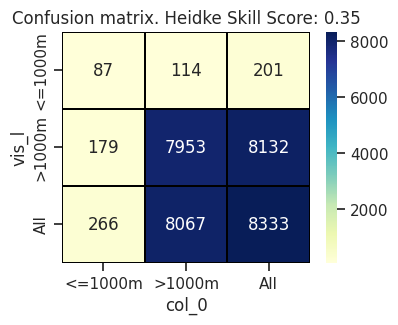

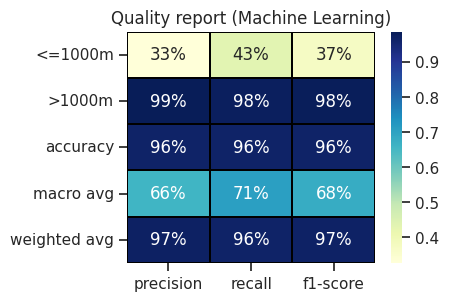

feature feature_per
102    dayofyear        3.7%
100         hour        3.4%
25          dir1        2.0%
58   visibility2        1.8%
29    wind_gust1        1.8%
74         T8502        1.8%
101        month        1.8%
8    visibility0        1.7%
33   visibility1        1.6%
83   visibility3        1.6%

Round 1


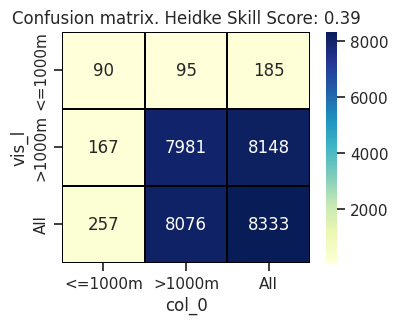

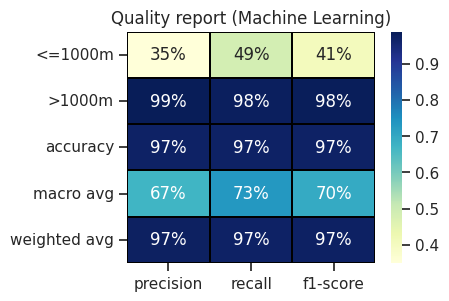

feature feature_per
100         hour        3.5%
102    dayofyear        3.3%
25          dir1        1.9%
58   visibility2        1.9%
33   visibility1        1.8%
29    wind_gust1        1.8%
42          cfh1        1.8%
31         temp1        1.7%
8    visibility0        1.6%
55         mslp2        1.6%

Round 2


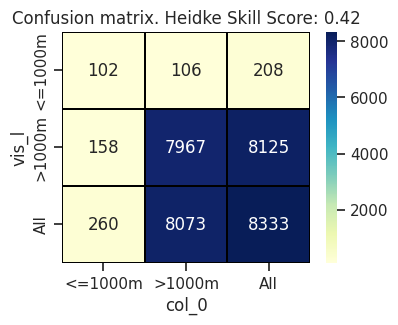

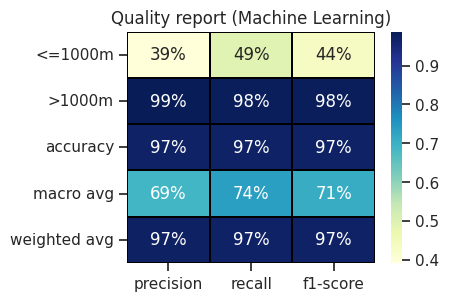

feature feature_per
100         hour        3.4%
102    dayofyear        3.4%
25          dir1        2.1%
8    visibility0        1.9%
33   visibility1        1.8%
58   visibility2        1.8%
42          cfh1        1.7%
101        month        1.7%
83   visibility3        1.7%
4     wind_gust0        1.6%

Round 3


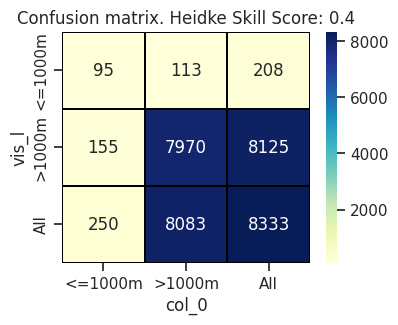

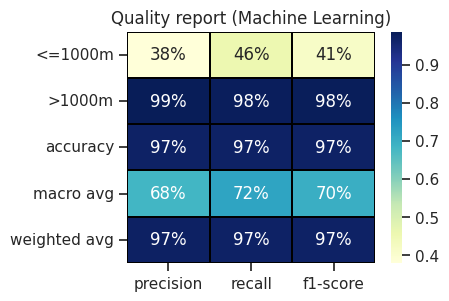

feature feature_per
102    dayofyear        3.4%
100         hour        3.2%
58   visibility2        2.2%
33   visibility1        2.1%
101        month        1.9%
83   visibility3        1.8%
54    wind_gust2        1.8%
84        lhflx3        1.8%
34        lhflx1        1.7%
25          dir1        1.6%

Round 4


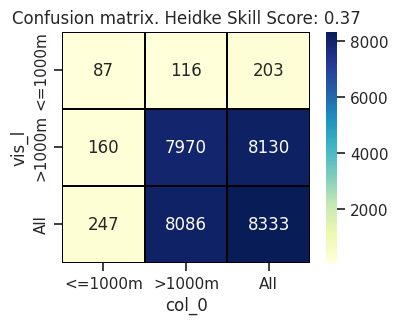

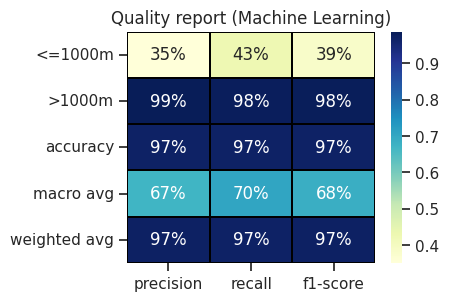

feature feature_per
100         hour        3.3%
102    dayofyear        3.3%
58   visibility2        2.0%
101        month        1.8%
33   visibility1        1.8%
25          dir1        1.8%
31         temp1        1.8%
8    visibility0        1.8%
4     wind_gust0        1.7%
42          cfh1        1.6%

Round 5


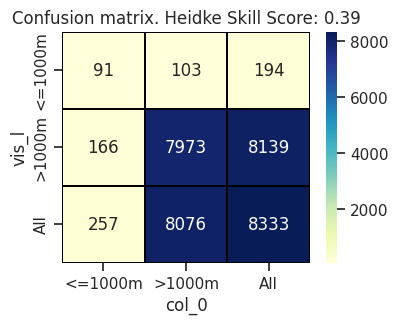

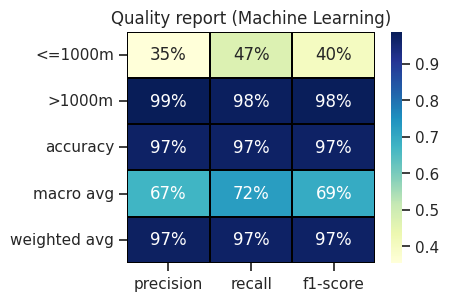

feature feature_per
100         hour        3.5%
102    dayofyear        3.4%
58   visibility2        2.3%
101        month        2.0%
33   visibility1        2.0%
25          dir1        1.9%
32           rh1        1.8%
4     wind_gust0        1.7%
84        lhflx3        1.6%
54    wind_gust2        1.6%

Round 6


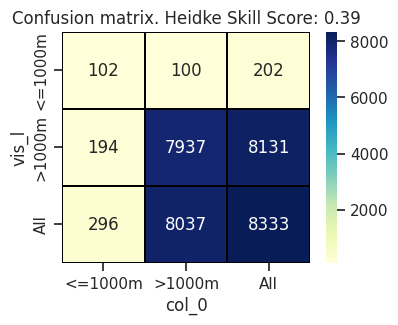

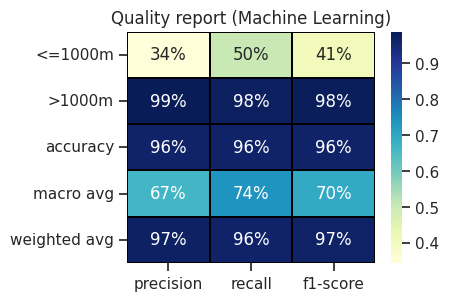

feature feature_per
100         hour        3.4%
102    dayofyear        3.0%
74         T8502        1.9%
54    wind_gust2        1.9%
58   visibility2        1.8%
101        month        1.8%
8    visibility0        1.7%
29    wind_gust1        1.7%
32           rh1        1.7%
84        lhflx3        1.6%

Round 7


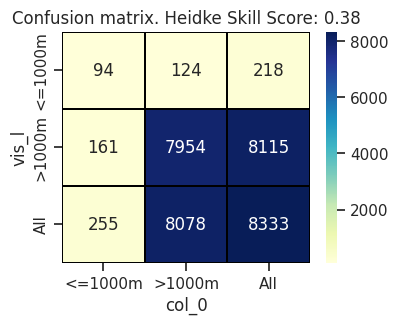

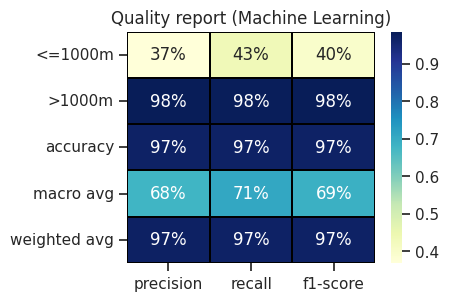

feature feature_per
100         hour        3.2%
102    dayofyear        3.0%
58   visibility2        2.1%
25          dir1        1.8%
33   visibility1        1.8%
101        month        1.8%
34        lhflx1        1.7%
29    wind_gust1        1.7%
54    wind_gust2        1.6%
42          cfh1        1.6%

Round 8


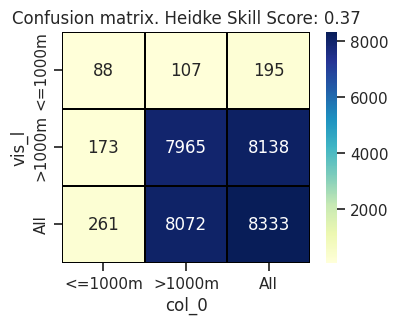

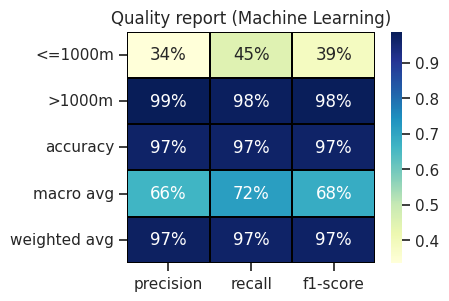

feature feature_per
102    dayofyear        3.9%
100         hour        3.5%
25          dir1        1.8%
101        month        1.8%
4     wind_gust0        1.8%
33   visibility1        1.8%
29    wind_gust1        1.8%
58   visibility2        1.7%
8    visibility0        1.7%
83   visibility3        1.7%

Round 9


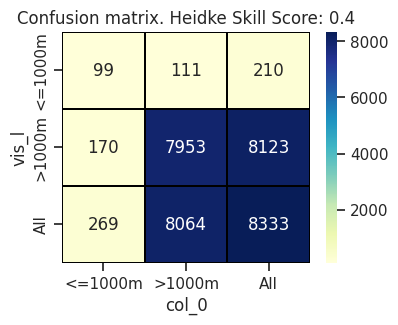

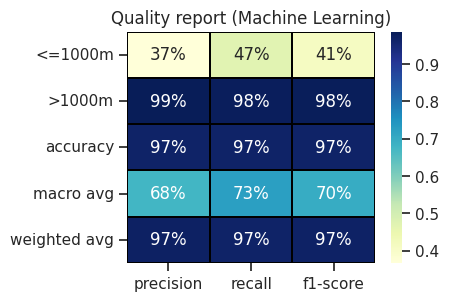

feature feature_per
100         hour        3.5%
102    dayofyear        3.1%
58   visibility2        2.2%
29    wind_gust1        1.9%
33   visibility1        1.9%
32           rh1        1.8%
101        month        1.7%
25          dir1        1.7%
4     wind_gust0        1.6%
0           dir0        1.6%


HSS stadistics
             HSS
count  10.000000
mean    0.385919
std     0.018342
min     0.354864
25%     0.372354
50%     0.389411
75%     0.395235
max     0.419806
Shapiro test normality
p value: 0.9120562672615051
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 4.755666381309278e-288
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1315.5352408958572
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.24 minutes


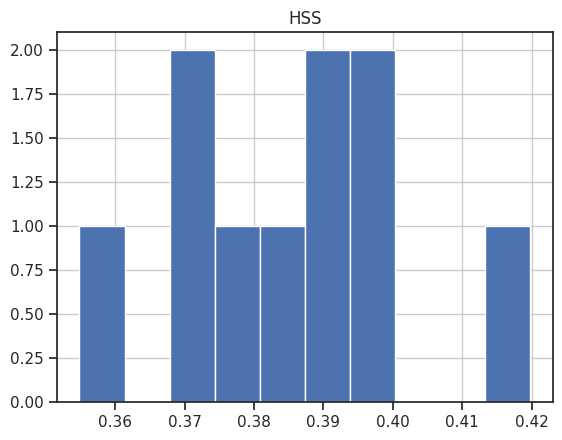

In [9]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [10]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/vis_LEST_d0.al", 'wb'))

Round 0


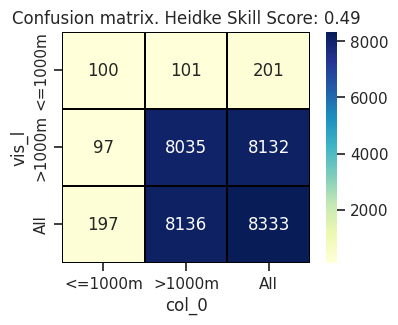

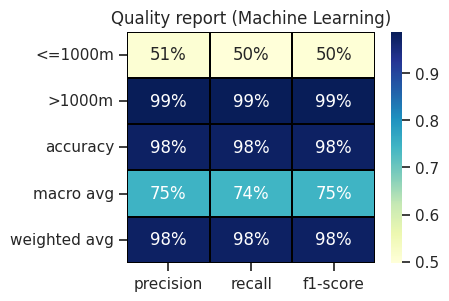

feature feature_per
100         hour        3.9%
32           rh1        3.5%
8    visibility0        2.8%
33   visibility1        2.7%
83   visibility3        2.6%
79    wind_gust3        2.6%
54    wind_gust2        2.6%
29    wind_gust1        2.6%
4     wind_gust0        2.5%
84        lhflx3        2.5%

Round 1


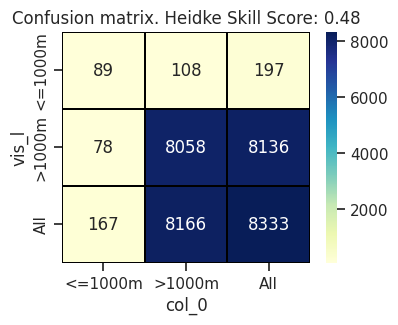

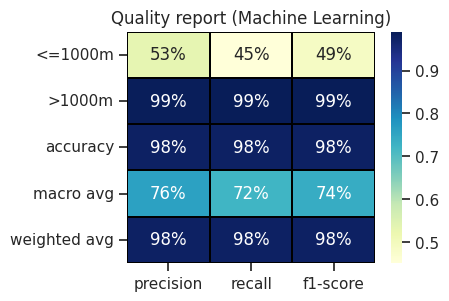

feature feature_per
100         hour        4.5%
8    visibility0        3.1%
32           rh1        3.1%
4     wind_gust0        3.0%
54    wind_gust2        3.0%
83   visibility3        2.9%
29    wind_gust1        2.9%
82           rh3        2.7%
7            rh0        2.5%
79    wind_gust3        2.5%

Round 2


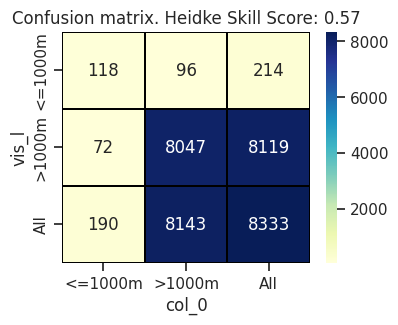

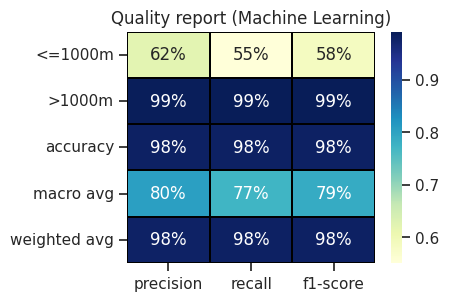

feature feature_per
100         hour        3.9%
8    visibility0        3.6%
82           rh3        3.2%
79    wind_gust3        3.0%
29    wind_gust1        2.9%
4     wind_gust0        2.7%
83   visibility3        2.7%
33   visibility1        2.7%
57           rh2        2.6%
59        lhflx2        2.6%

Round 3


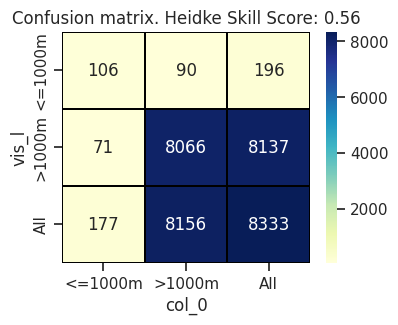

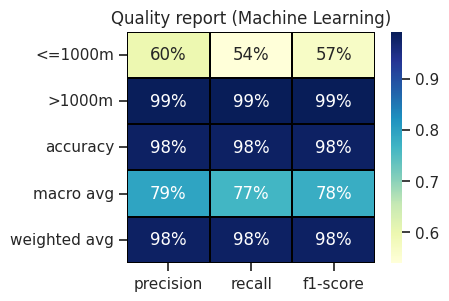

feature feature_per
100         hour        4.0%
32           rh1        3.5%
8    visibility0        3.1%
29    wind_gust1        3.0%
83   visibility3        3.0%
33   visibility1        2.9%
3           mod0        2.7%
82           rh3        2.6%
57           rh2        2.6%
54    wind_gust2        2.5%

Round 4


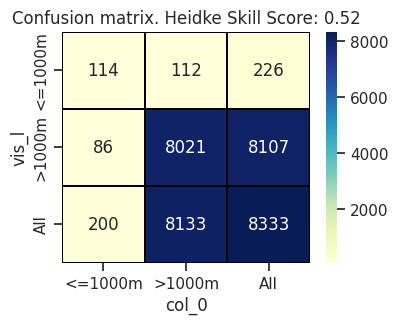

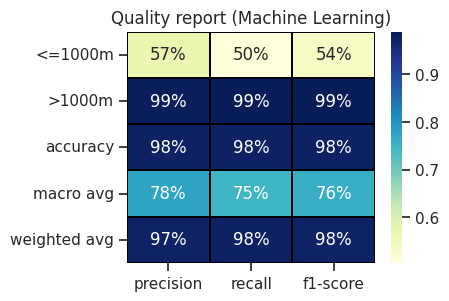

feature feature_per
83   visibility3        3.8%
100         hour        3.7%
33   visibility1        3.4%
32           rh1        3.2%
79    wind_gust3        3.1%
29    wind_gust1        2.7%
84        lhflx3        2.6%
54    wind_gust2        2.5%
7            rh0        2.4%
82           rh3        2.4%

Round 5


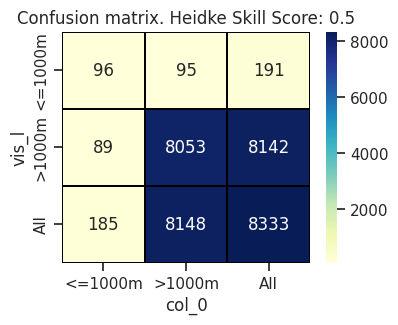

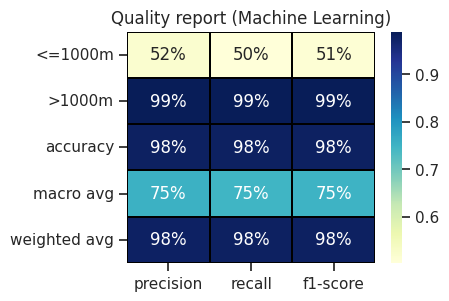

feature feature_per
100         hour        4.0%
7            rh0        3.6%
32           rh1        3.2%
4     wind_gust0        2.8%
33   visibility1        2.8%
34        lhflx1        2.7%
29    wind_gust1        2.6%
8    visibility0        2.6%
78          mod3        2.6%
83   visibility3        2.5%

Round 6


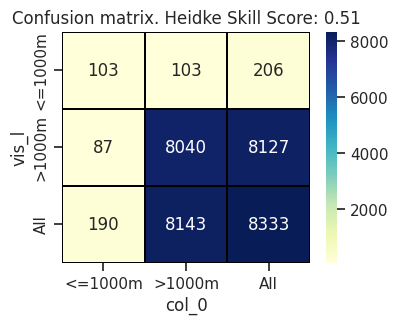

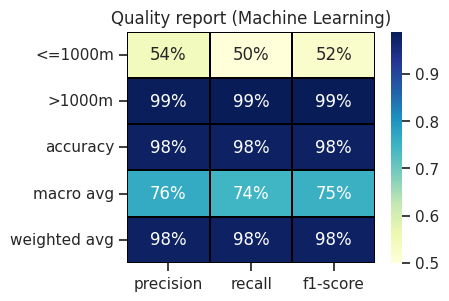

feature feature_per
100         hour        3.8%
33   visibility1        3.4%
32           rh1        3.0%
57           rh2        3.0%
3           mod0        2.9%
28          mod1        2.8%
29    wind_gust1        2.7%
82           rh3        2.6%
54    wind_gust2        2.6%
8    visibility0        2.5%

Round 7


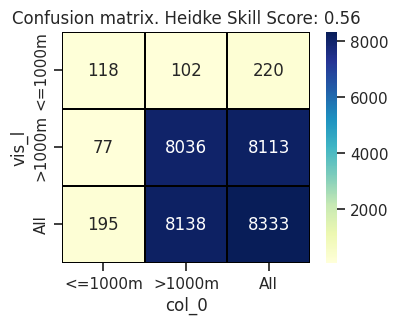

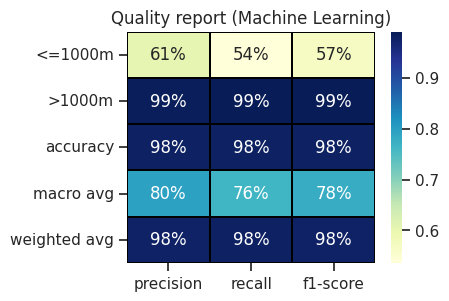

feature feature_per
100         hour        4.6%
33   visibility1        3.3%
7            rh0        3.3%
29    wind_gust1        2.8%
8    visibility0        2.8%
82           rh3        2.6%
32           rh1        2.5%
78          mod3        2.5%
3           mod0        2.4%
57           rh2        2.4%

Round 8


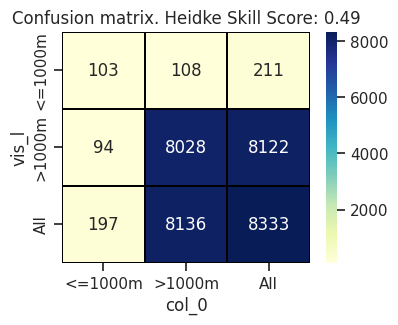

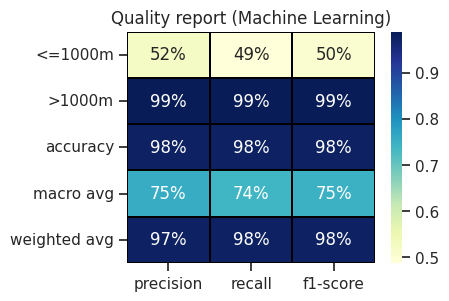

feature feature_per
100         hour        4.4%
57           rh2        3.7%
32           rh1        3.4%
79    wind_gust3        2.9%
83   visibility3        2.7%
33   visibility1        2.7%
78          mod3        2.6%
8    visibility0        2.5%
7            rh0        2.5%
29    wind_gust1        2.5%

Round 9


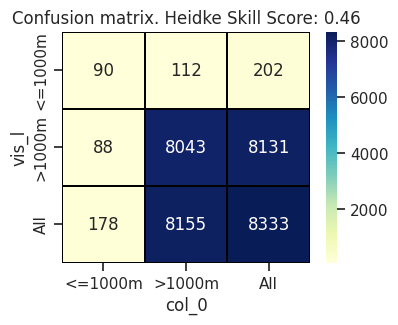

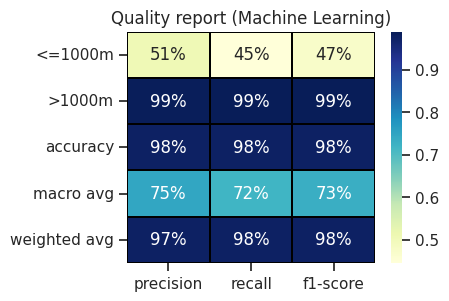

feature feature_per
100         hour        3.9%
33   visibility1        3.5%
82           rh3        3.4%
4     wind_gust0        3.1%
32           rh1        3.0%
29    wind_gust1        2.7%
83   visibility3        2.7%
54    wind_gust2        2.4%
79    wind_gust3        2.4%
84        lhflx3        2.4%


HSS stadistics
             HSS
count  10.000000
mean    0.514300
std     0.037864
min     0.461454
25%     0.490880
50%     0.503945
75%     0.549042
max     0.573865
Shapiro test normality
p value: 0.4648069739341736
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1761.1331742488258
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 3.05 minutes


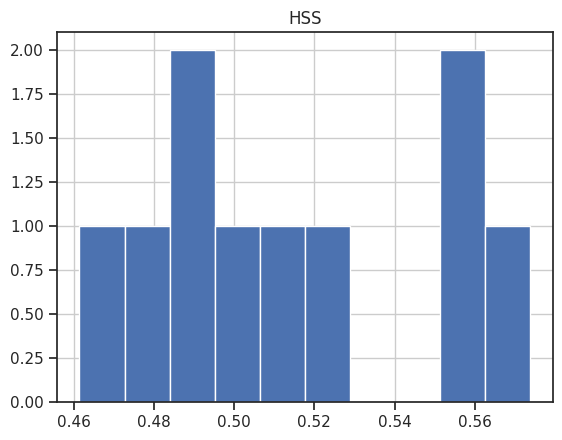

In [11]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")







In [12]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/brfg_LEST_d0.al", 'wb'))

*****************************


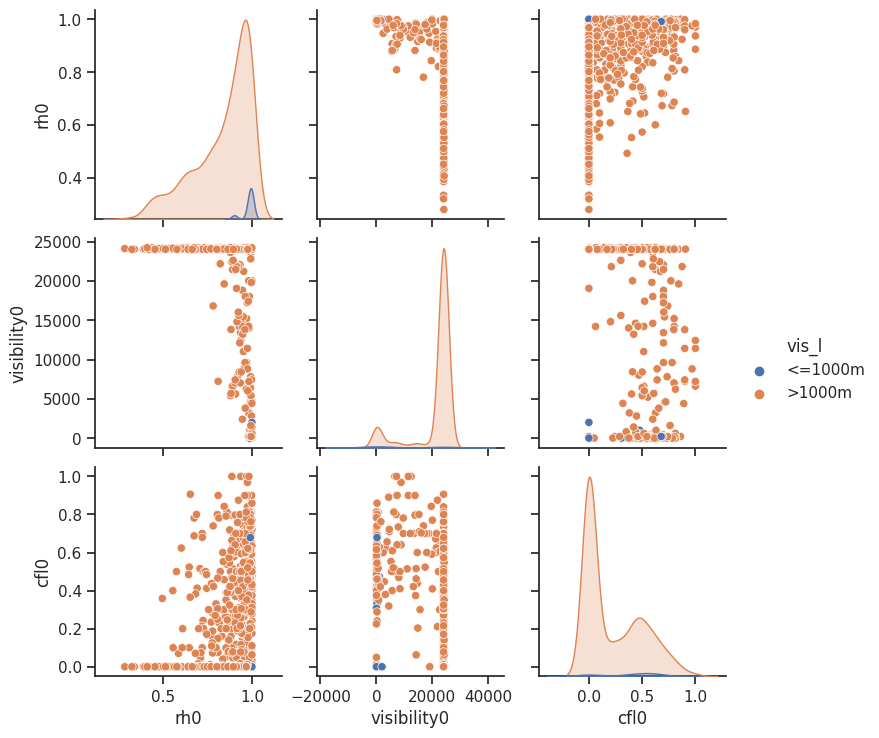

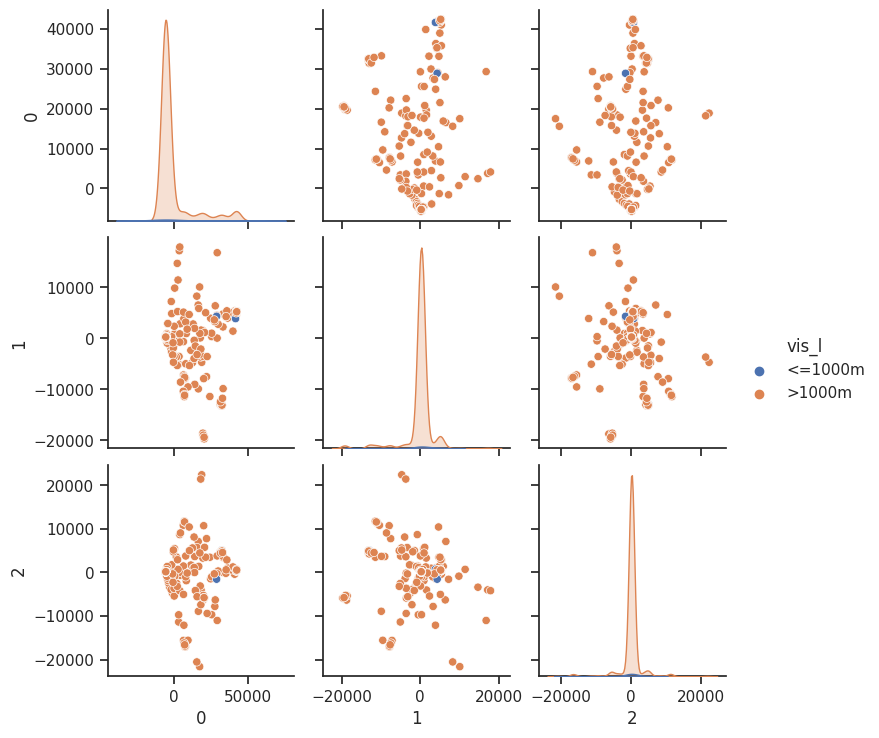

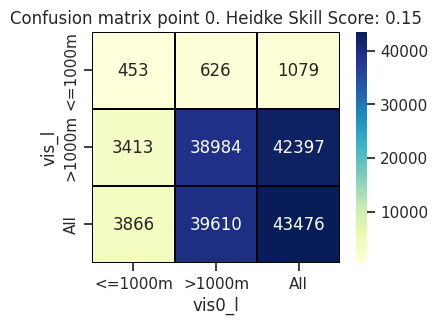

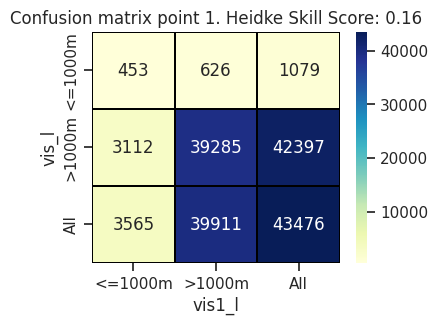

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 1491.3254203148726
Reject H0,There is an association between machine learning forecast and observed values


In [13]:
#@title Load meteorological model forecast D1.Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["visibility_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["vis_l","rh0","visibility0","cfl0"]].sample(1000)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="vis_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["vis_l"] = df_all.vis_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(1000), hue="vis_l");
plt.show()

#label meteorological model variables dir0 and dir1
df_all["vis0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all["vis1_l"] = pd.cut(df_all["visibility1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.vis_l, df_all.vis0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
cm1 = pd.crosstab(df_all.vis_l, df_all.vis1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")


Round 0


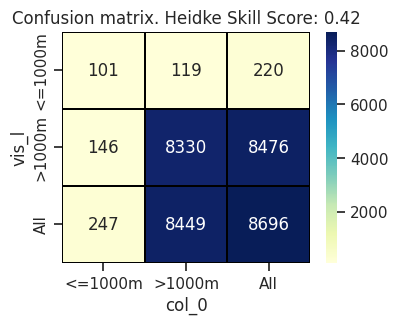

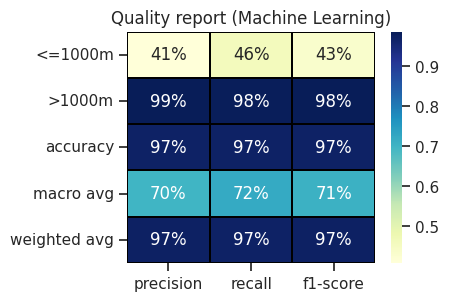

feature feature_per
100         hour        3.9%
102    dayofyear        3.5%
58   visibility2        2.4%
54    wind_gust2        1.8%
50          dir2        1.8%
101        month        1.8%
37         prec1        1.7%
7            rh0        1.7%
39        shflx1        1.7%
62         prec2        1.7%

Round 1


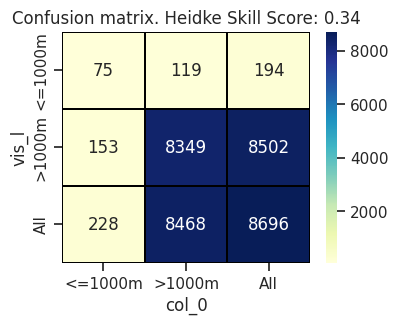

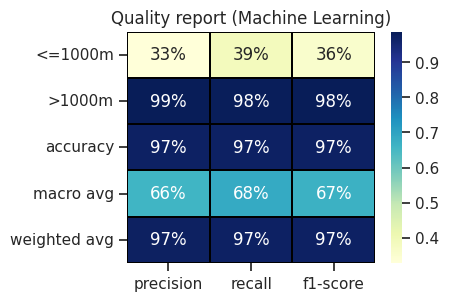

feature feature_per
100         hour        3.8%
102    dayofyear        3.6%
33   visibility1        2.1%
62         prec2        2.0%
54    wind_gust2        2.0%
58   visibility2        2.0%
59        lhflx2        1.9%
50          dir2        1.9%
42          cfh1        1.8%
39        shflx1        1.8%

Round 2


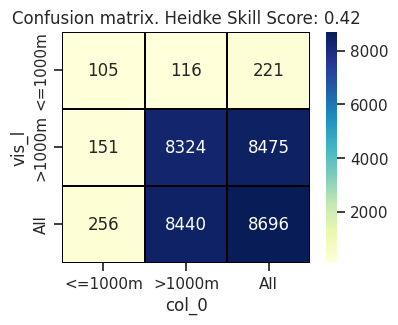

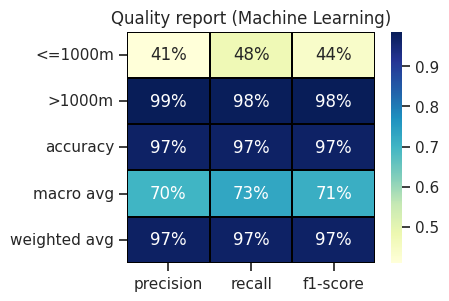

feature feature_per
102    dayofyear        3.5%
100         hour        3.3%
50          dir2        2.1%
33   visibility1        1.9%
54    wind_gust2        1.9%
39        shflx1        1.9%
37         prec1        1.9%
58   visibility2        1.8%
62         prec2        1.7%
7            rh0        1.7%

Round 3


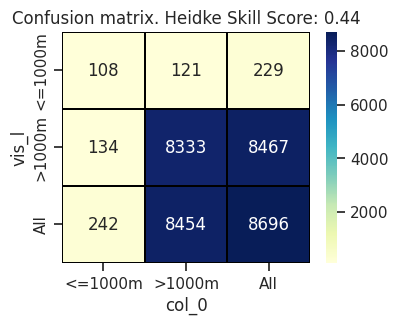

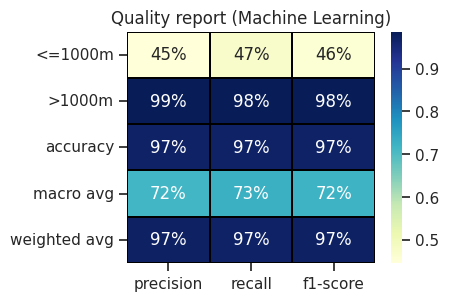

feature feature_per
100         hour        3.9%
102    dayofyear        3.2%
58   visibility2        2.1%
37         prec1        1.9%
50          dir2        1.9%
54    wind_gust2        1.9%
101        month        1.8%
33   visibility1        1.6%
39        shflx1        1.6%
32           rh1        1.6%

Round 4


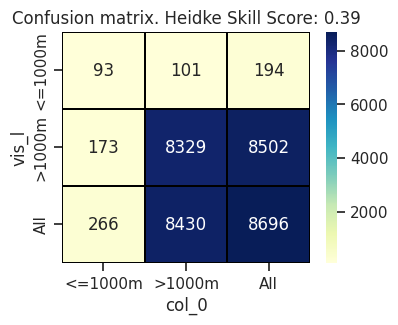

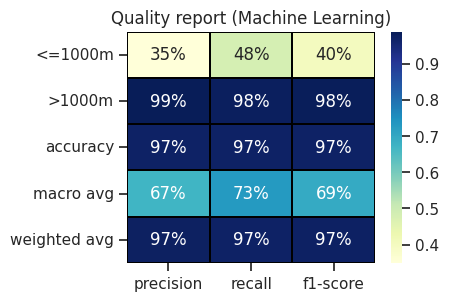

feature feature_per
102    dayofyear        3.8%
100         hour        3.5%
58   visibility2        2.4%
54    wind_gust2        2.1%
37         prec1        2.1%
50          dir2        2.1%
7            rh0        2.0%
33   visibility1        1.9%
62         prec2        1.9%
39        shflx1        1.7%

Round 5


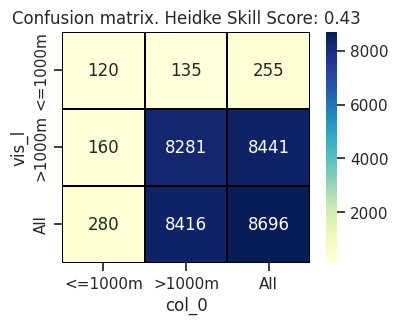

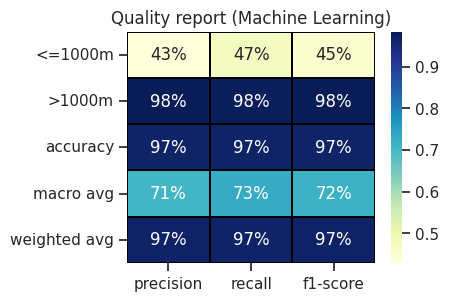

feature feature_per
102    dayofyear        3.6%
100         hour        3.6%
62         prec2        2.3%
54    wind_gust2        2.1%
58   visibility2        2.1%
33   visibility1        2.0%
101        month        1.9%
37         prec1        1.8%
50          dir2        1.7%
39        shflx1        1.6%

Round 6


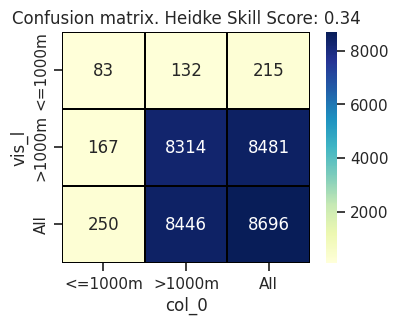

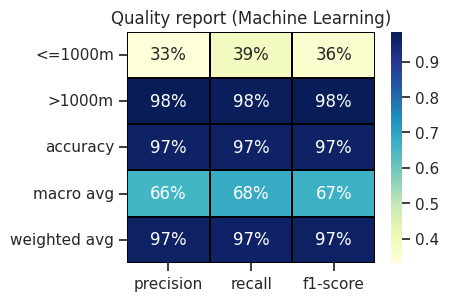

feature feature_per
100         hour        3.5%
102    dayofyear        3.4%
58   visibility2        2.1%
101        month        2.0%
50          dir2        1.9%
54    wind_gust2        1.9%
62         prec2        1.8%
83   visibility3        1.8%
39        shflx1        1.8%
37         prec1        1.6%

Round 7


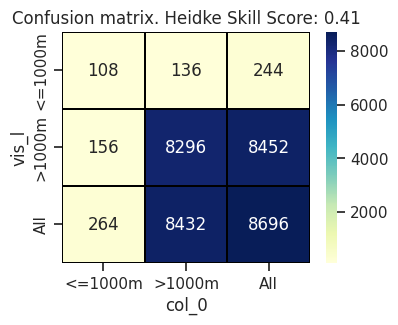

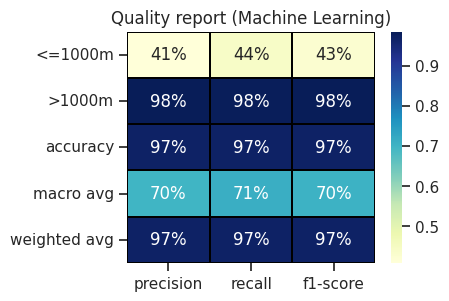

feature feature_per
102    dayofyear        3.8%
100         hour        3.5%
58   visibility2        2.1%
50          dir2        1.9%
101        month        1.8%
39        shflx1        1.7%
54    wind_gust2        1.7%
62         prec2        1.7%
37         prec1        1.7%
7            rh0        1.5%

Round 8


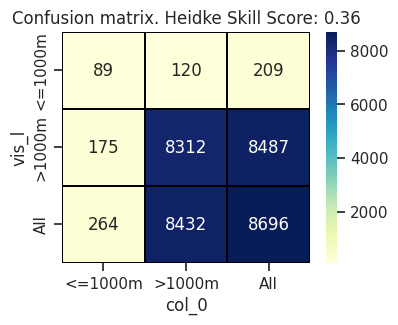

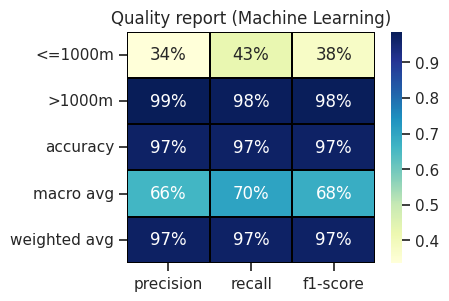

feature feature_per
100         hour        3.8%
102    dayofyear        3.5%
50          dir2        2.1%
62         prec2        2.1%
54    wind_gust2        2.1%
58   visibility2        2.0%
7            rh0        1.9%
60        lwflx2        1.8%
37         prec1        1.8%
33   visibility1        1.7%

Round 9


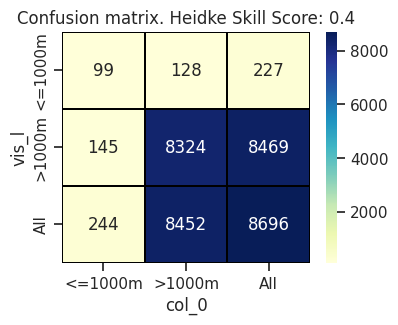

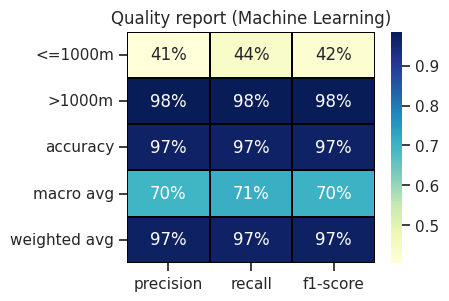

feature feature_per
100         hour        3.7%
102    dayofyear        3.5%
58   visibility2        2.1%
54    wind_gust2        1.9%
50          dir2        1.9%
101        month        1.8%
83   visibility3        1.7%
39        shflx1        1.6%
42          cfh1        1.6%
7            rh0        1.6%


HSS stadistics
             HSS
count  10.000000
mean    0.395503
std     0.037655
min     0.339428
25%     0.366489
50%     0.406100
75%     0.422652
max     0.443540
Shapiro test normality
p value: 0.2543318271636963
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 4.116008265279913e-308
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1407.8598228706353
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.23 minutes


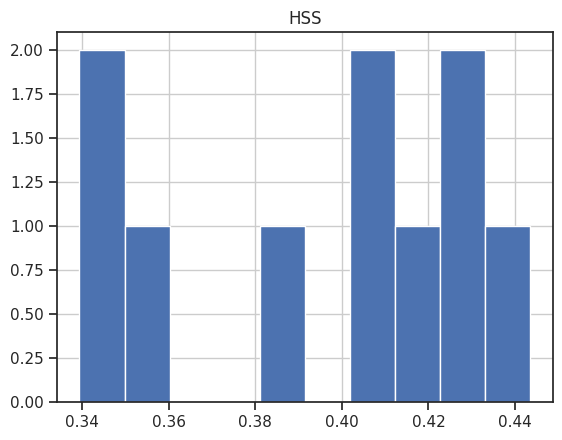

In [14]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score
start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [15]:
#@title Save last algorithm round 9

x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/vis_LEST_d1.al", 'wb'))


Round 0


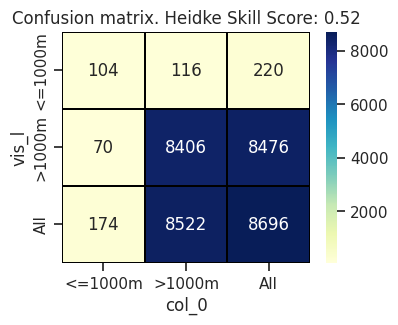

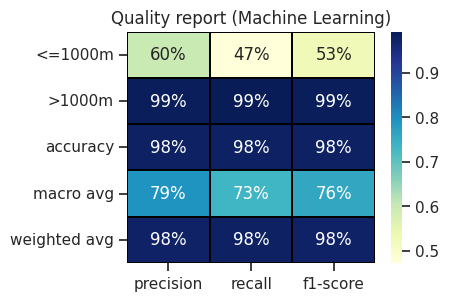

feature feature_per
100         hour        4.8%
33   visibility1        3.0%
54    wind_gust2        3.0%
4     wind_gust0        2.8%
79    wind_gust3        2.6%
7            rh0        2.6%
83   visibility3        2.4%
32           rh1        2.4%
8    visibility0        2.4%
57           rh2        2.3%

Round 1


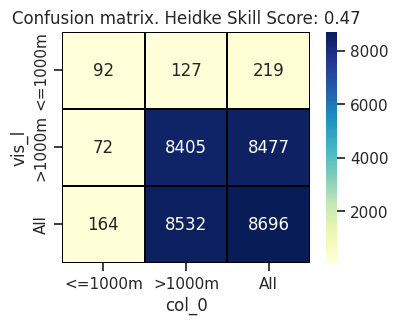

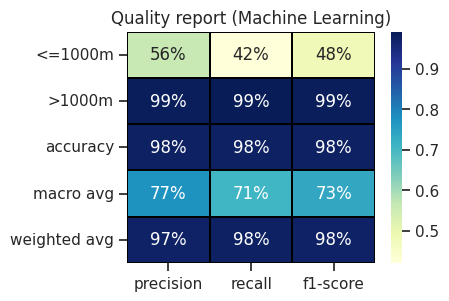

feature feature_per
33   visibility1        4.0%
100         hour        3.9%
8    visibility0        3.3%
79    wind_gust3        2.9%
82           rh3        2.8%
4     wind_gust0        2.6%
59        lhflx2        2.6%
54    wind_gust2        2.4%
7            rh0        2.4%
29    wind_gust1        2.3%

Round 2


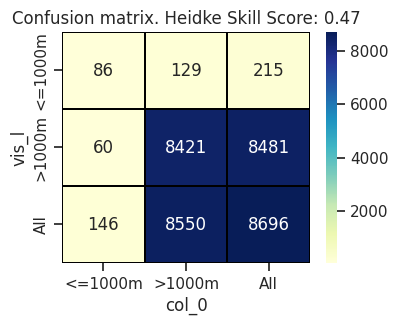

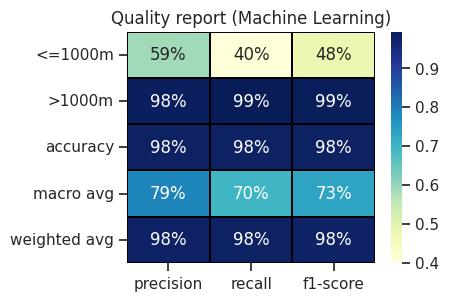

feature feature_per
100         hour        3.9%
4     wind_gust0        3.0%
33   visibility1        2.9%
29    wind_gust1        2.8%
8    visibility0        2.8%
79    wind_gust3        2.5%
83   visibility3        2.5%
54    wind_gust2        2.5%
84        lhflx3        2.4%
82           rh3        2.3%

Round 3


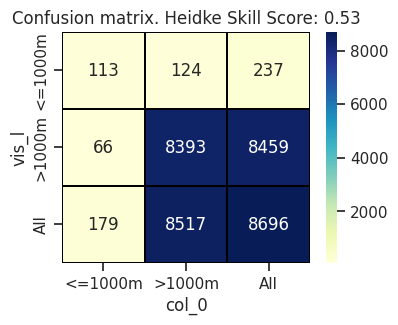

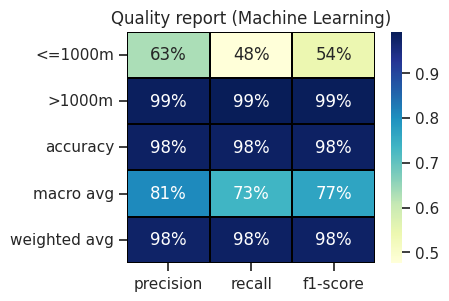

feature feature_per
100         hour        4.4%
33   visibility1        3.8%
79    wind_gust3        2.6%
8    visibility0        2.6%
4     wind_gust0        2.6%
28          mod1        2.5%
29    wind_gust1        2.3%
82           rh3        2.2%
57           rh2        2.1%
58   visibility2        2.1%

Round 4


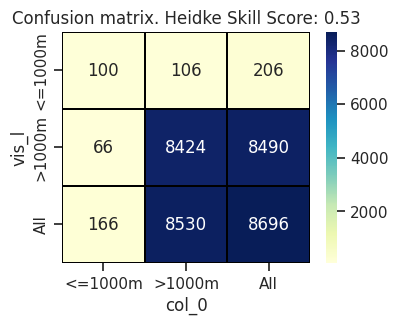

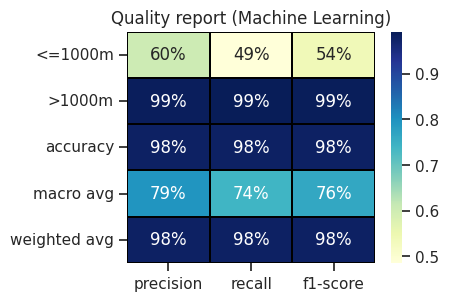

feature feature_per
100         hour        4.7%
8    visibility0        2.9%
33   visibility1        2.8%
58   visibility2        2.8%
4     wind_gust0        2.5%
59        lhflx2        2.4%
79    wind_gust3        2.4%
83   visibility3        2.4%
32           rh1        2.3%
57           rh2        2.2%

Round 5


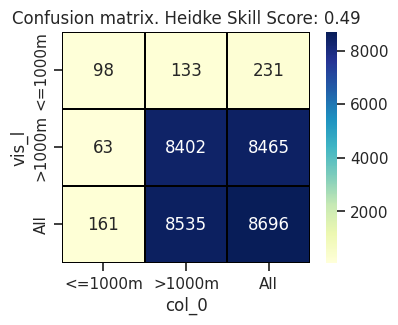

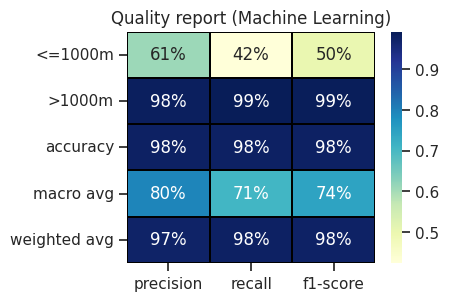

feature feature_per
100         hour        4.3%
54    wind_gust2        2.9%
33   visibility1        2.7%
7            rh0        2.6%
83   visibility3        2.6%
32           rh1        2.5%
79    wind_gust3        2.5%
82           rh3        2.4%
84        lhflx3        2.4%
8    visibility0        2.3%

Round 6


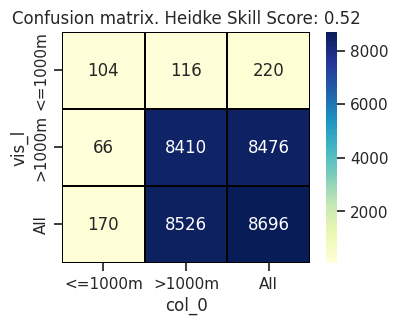

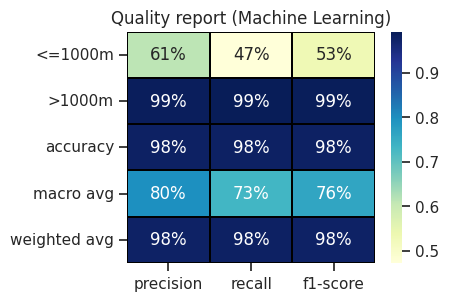

feature feature_per
100         hour        4.4%
29    wind_gust1        3.1%
83   visibility3        3.0%
8    visibility0        2.9%
54    wind_gust2        2.5%
57           rh2        2.4%
82           rh3        2.4%
32           rh1        2.3%
79    wind_gust3        2.2%
33   visibility1        2.1%

Round 7


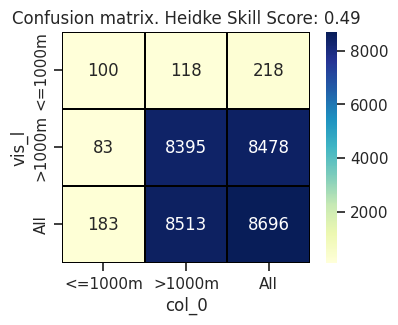

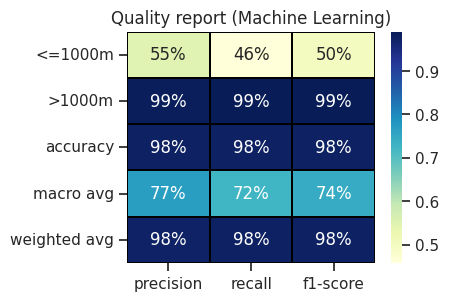

feature feature_per
100         hour        3.9%
54    wind_gust2        3.0%
33   visibility1        2.9%
82           rh3        2.7%
8    visibility0        2.6%
7            rh0        2.6%
29    wind_gust1        2.5%
32           rh1        2.4%
79    wind_gust3        2.4%
57           rh2        2.3%

Round 8


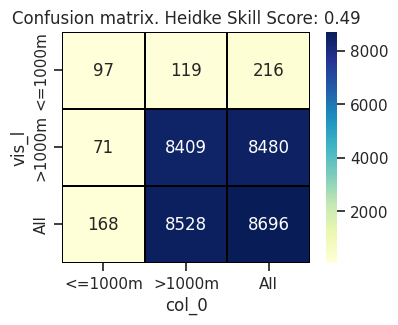

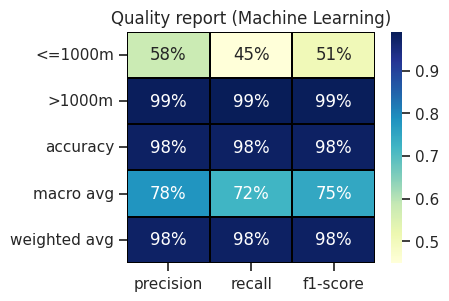

feature feature_per
100         hour        4.1%
8    visibility0        3.3%
54    wind_gust2        3.1%
82           rh3        2.9%
32           rh1        2.8%
4     wind_gust0        2.7%
83   visibility3        2.5%
79    wind_gust3        2.4%
33   visibility1        2.4%
57           rh2        2.3%

Round 9


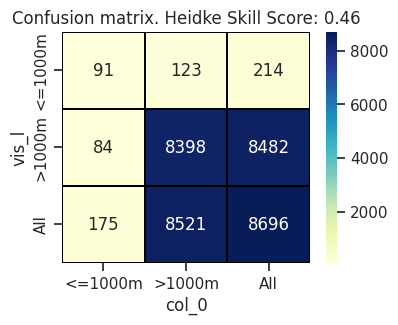

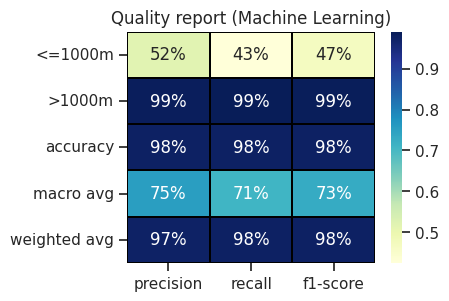

feature feature_per
100         hour        3.9%
7            rh0        2.8%
79    wind_gust3        2.6%
82           rh3        2.5%
83   visibility3        2.5%
8    visibility0        2.5%
33   visibility1        2.4%
84        lhflx3        2.4%
32           rh1        2.4%
57           rh2        2.4%


HSS stadistics
             HSS
count  10.000000
mean    0.496052
std     0.027646
min     0.455817
25%     0.473477
50%     0.491531
75%     0.521389
max     0.532300
Shapiro test normality
p value: 0.3842129409313202
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1804.9542016649518
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 3.24 minutes


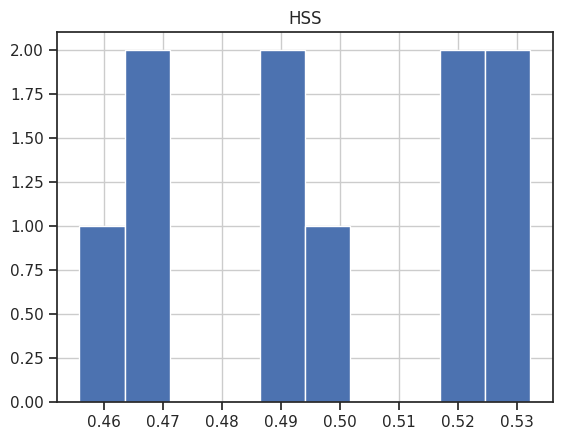

In [16]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [17]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/vis_LEST_d1.al", 'wb'))